In [55]:
from Bio import SeqIO
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import numpy as np

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'

import re
from collections import defaultdict

In [10]:
phylogeny_order = ['Chanos_chanos',
    'Triplophysa_siluroides',
    'Triplophysa_tibetana',
    'Triplophysa_dalaica',
    'Danionella_dracula',
    'Danionella_translucida',
    'Danio_jaintianensis',
    'Danio_choprai',
    'Danio_albolineatus',
    'Danio_aesculapii',
    'Danio_rerio',
    'Danio_kyathit',
    'Danio_tinwini',
    'Leuciscus_waleckii',
    'Gobiocypris_rarus',
    'Paracanthobrama_guichenoti',
    'Ctenopharyngodon_idella',
    'Hypophthalmichthys_molitrix',
    'Anabarilius_grahami',
    'Culter_alburnus',
    'Megalobrama_amblycephala',
    'Labeo_rohita',
    'Labeo_catla',
    'Puntigrus_tetrazona',
    'Oxygymnocypris_stewartii',
    'Onychostoma_macrolepis',
    'Cyprinus_carpio',
    'Carassius_auratus',
    'Sinocyclocheilus_rhinocerous',
    'Sinocyclocheilus_anshuiensis',
    'Sinocyclocheilus_grahami',
    'Sinocyclocheilus_maitianheensis',
    'Sinocyclocheilus_anophthalmus'
]

In [11]:
def count_finz_znf(species):
    count = 0
    with open('../data/seqs/cypriniformes_augustus_finz.fa') as infile:
        for line in infile:
            if line.startswith(f'>{species}'):
                count += 1
    return count

count_df = pd.DataFrame({'species': phylogeny_order})
count_df['finz_znf'] = count_df.species.apply(count_finz_znf)
print(count_df)

                            species  finz_znf
0                     Chanos_chanos         0
1            Triplophysa_siluroides         0
2              Triplophysa_tibetana         0
3               Triplophysa_dalaica         0
4                Danionella_dracula         4
5            Danionella_translucida         9
6               Danio_jaintianensis        93
7                     Danio_choprai        64
8                Danio_albolineatus       334
9                  Danio_aesculapii       389
10                      Danio_rerio       684
11                    Danio_kyathit       593
12                    Danio_tinwini        96
13               Leuciscus_waleckii       106
14                Gobiocypris_rarus       322
15       Paracanthobrama_guichenoti       347
16          Ctenopharyngodon_idella       235
17      Hypophthalmichthys_molitrix        16
18              Anabarilius_grahami       294
19                  Culter_alburnus       358
20         Megalobrama_amblycephal

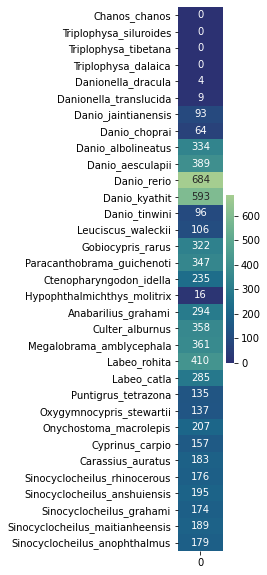

In [45]:
nfinz = [[0]]
for sp in phylogeny_order[1:]:
    nfinz.append(list(count_df.loc[count_df.species == sp, 'finz_znf']))
    
plt.figure(figsize=(1,10))
hm = sns.heatmap(nfinz, cmap='crest_r', annot=True, fmt='d', yticklabels=phylogeny_order)

plt.savefig('../figs/nfinz_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
seqdict = {}
for record in SeqIO.parse('../data/seqs/cypriniformes_augustus_finz.fa', 'fasta'):
    seqdict[record.id] = str(record.seq)

In [14]:
seqlens = [(key, len(val)) for key, val in seqdict.items()]
seq_df = pd.DataFrame(seqlens, columns=['name', 'length'])
seq_df['species'] = seq_df.name.apply(lambda x: '_'.join(x.split('_')[:2]))
print(seq_df.head())

                        name  length              species
0  Danio_jaintianensis_g2.t1     294  Danio_jaintianensis
1  Danio_jaintianensis_g4.t1     418  Danio_jaintianensis
2  Danio_jaintianensis_g5.t1     546  Danio_jaintianensis
3  Danio_jaintianensis_g6.t1     306  Danio_jaintianensis
4  Danio_jaintianensis_g7.t1     482  Danio_jaintianensis


In [15]:
def extract_exons(species, genelist):
    exons = defaultdict(int)
    with open(f'../data/gffs/{species}_augustus_finz.gff') as infile:
        for line in infile:
            if line.startswith('#'):
                continue
            line = line.split()
            if line[2] != 'CDS':
                continue
            parent = re.search('Parent=(.+)$', line[8]).group(1)
            exons[f'{species}_{parent}'] += 1
    return {key: exons[key] for key in genelist}

In [16]:
for species in set(seq_df.species.tolist()):
    genelist = seq_df.loc[seq_df.species == species, 'name'].tolist()
    exons = extract_exons(species, genelist)
    seq_df.loc[seq_df.species == species, 'exons'] = seq_df['name'].apply(exons.get)
print(seq_df.head())

                        name  length              species  exons
0  Danio_jaintianensis_g2.t1     294  Danio_jaintianensis    7.0
1  Danio_jaintianensis_g4.t1     418  Danio_jaintianensis    4.0
2  Danio_jaintianensis_g5.t1     546  Danio_jaintianensis    4.0
3  Danio_jaintianensis_g6.t1     306  Danio_jaintianensis    5.0
4  Danio_jaintianensis_g7.t1     482  Danio_jaintianensis    4.0


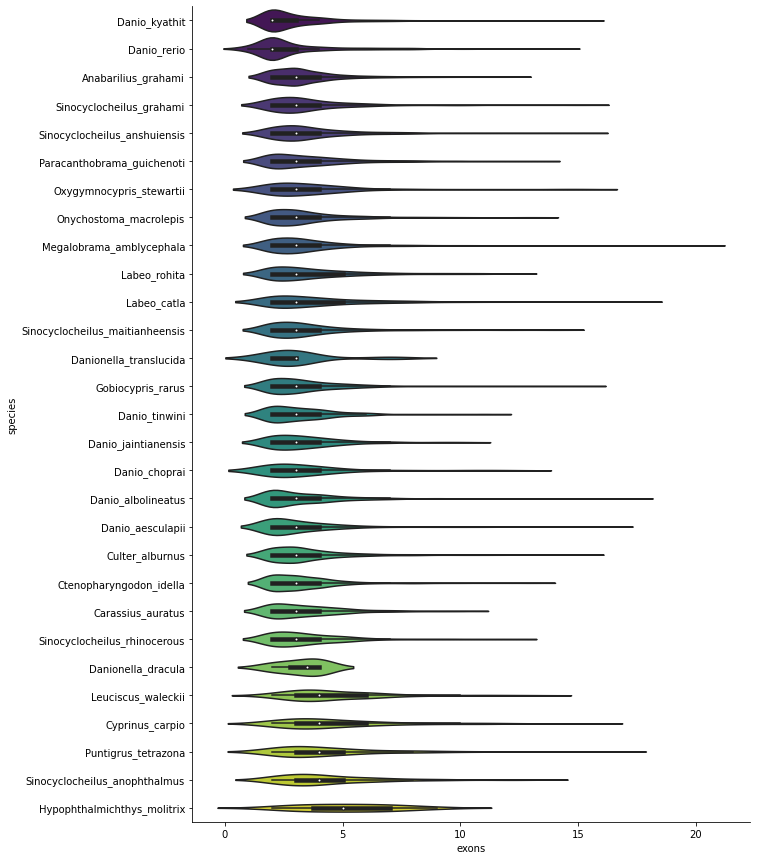

In [17]:
sortorder = seq_df.groupby('species').median().reset_index().sort_values('exons').species.tolist()
fig, ax = plt.subplots(figsize=(10, 15))
sns.violinplot(data=seq_df, x='exons', y='species', order=sortorder, palette='viridis')
sns.despine()
plt.show()

/Users/jonwells/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inched" which is no longer supported as of 3.3 and will become an error two minor releases later
  if sys.path[0] == '':


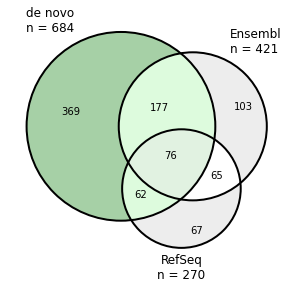

In [60]:
with open('../data/finz_znf_overlap_70.txt') as infile:
    # (A, B, AB, C, AC, BC, ABC)
    overlap = [int(line.split()[-1]) for line in infile]
denovo = overlap[0] + overlap[2] + overlap[4] + overlap[6]
ensembl = overlap[1] + overlap[2] + overlap[5] + overlap[6]
refseq = overlap[3] + overlap[4] + overlap[5] + overlap[6]
fig, ax = plt.subplots(figsize=(5, 5))
venn3(subsets=overlap, 
      set_labels=(f'de novo\nn = {denovo}', f'Ensembl\nn = {ensembl}', f'RefSeq\nn = {refseq}'), 
      set_colors=('forestgreen', 'lightgray', 'lightgray'))
venn3_circles(subsets=overlap, linestyle='-')
fig.savefig('../figs/annotation_venn.pdf', dpi=300, bbox_inched='tight')
plt.show()


In [40]:
print('denovo', overlap[0] + overlap[2] + overlap[4] + overlap[6])
print('ensembl', overlap[1] + overlap[2] + overlap[5] + overlap[6])
print('refseq', overlap[3] + overlap[4] + overlap[5] + overlap[6])

denovo 684
ensembl 421
refseq 270


In [34]:
print(177+76)

253
